## 데이터 이해 및 대회 목표 확인
* 목표: 월마트 판매량 예측
    * 5년 반동안의 과거데이터를 기반으로 다음 28일동안의 일일 판매 예측
    * 미국 3개 주 10개 매장: 캘리포니아(CA), 텍사스(TX), 위스콘신(WI)
    * 3개 범주 (hobbies, foods, household)와 7개 부서 (범주 하위항목 ex hobbies1, 2..)의 3049개의 개별 제품
    * 품목 수준, 부서, 제품 범주 및 매장 세부 정보, 가격, 프로모션, 요일, 특별 이벤트 이용


* 기대효과
    * 불확실성 수준 추정
    * cost가 큰 실수를 피함
    * 최상의 예측 사례 적용


![img](data/diagram.png)

In [2]:
import pandas as pd

calendar = pd.read_csv('data/calendar.csv')
sales_train_validation = pd.read_csv('data/sales_train_validation.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')
sell_prices = pd.read_csv('data/sell_prices.csv')
sales_train_evaluation = pd.read_csv('data/sales_train_evaluation.csv')


In [15]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


* date: The date in a “y-m-d” format.
* wm_yr_wk: The id of the week the date belongs to.
* weekday: The type of the day (Saturday, Sunday, …, Friday).
* wday: The id of the weekday, starting from Saturday.
* month: The month of the date.
* year: The year of the date.
* event_name_1: If the date includes an event, the name of this event.
* event_type_1: If the date includes an event, the type of this event.
* event_name_2: If the date includes a second event, the name of this event.
* event_type_2: If the date includes a second event, the type of this event.
* snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP  purchases on the examined date. 1 indicates that SNAP purchases are allowed.


* SNAP: “The Supplemental Nutrition Assistance Program (SNAP) is the largest federal nutrition assistance program. SNAP provides benefits to eligible low-income individuals and families via an Electronic Benefits Transfer card. This card can be used like a debit card to purchase eligible food in authorized retail food stores.”
    * 급식카드 사용 가능 매장같은..비슷한 개념인 듯

In [5]:
calendar[['event_name_1','event_type_1']].value_counts()

event_name_1         event_type_1
Mother's day         Cultural        6
Purim End            Religious       6
MemorialDay          National        6
LentWeek2            Religious       6
LentStart            Religious       6
Pesach End           Religious       6
NBAFinalsStart       Sporting        6
PresidentsDay        National        6
Ramadan starts       Religious       6
StPatricksDay        Cultural        6
SuperBowl            Sporting        6
ValentinesDay        Cultural        6
NBAFinalsEnd         Sporting        6
OrthodoxEaster       Religious       5
Thanksgiving         National        5
OrthodoxChristmas    Religious       5
NewYear              National        5
Chanukah End         Religious       5
Christmas            National        5
MartinLutherKingDay  National        5
LaborDay             National        5
IndependenceDay      National        5
Halloween            Cultural        5
EidAlAdha            Religious       5
Eid al-Fitr          Religious

* event는 국가 기념일 or 공휴일 표시인 듯
    * 같은 날 기념일이 겹칠 수 있으므로 2개까지 나타낸 듯

In [6]:
sales_train_validation

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


주요 훈련 데이터, 5년간 데이터, 상품, 지점별 하루 판매량

* item_id: The id of the product.
* dept_id: The id of the department the product belongs to.
* cat_id: The id of the category the product belongs to.
* store_id: The id of the store where the product is sold.
* state_id: The State where the store is located.
* d_1, d_2, …, d_i, … d_1941: The number of units sold at day i, starting from 2011-01-29.

In [7]:
sell_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


상점, 품목 id, 품목의 주당 평균 판매가격

* store_id: The id of the store where the product is sold. 
* item_id: The id of the product.
* wm_yr_wk: The id of the week.
* sell_price: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set). 

In [9]:
sales_train_evaluation

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


## EDA

In [46]:
date_range = pd.date_range(start = '2011-01-29', end = '2016-05-22', freq = 'D')
df = sales_train_validation.groupby('store_id').sum()

In [47]:
df = df.T
df.index = date_range[:-28]

Text(0, 0.5, 'Sales')

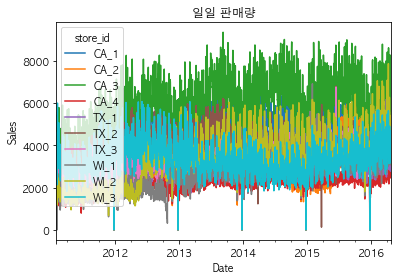

In [48]:
import matplotlib.pyplot as plt
plt.rcParams['font.family']= 'AppleGothic'
df.plot()
plt.title('일일 판매량')
plt.xlabel('Date')
plt.ylabel('Sales')

<AxesSubplot:xlabel='year,month'>

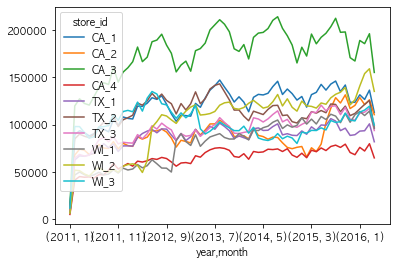

In [49]:
df['year'] = df.index.year
df['month'] = df.index.month
df.groupby(['year','month']).sum().plot()

In [53]:
date_df = pd.DataFrame()
date_df['date'] = pd.date_range(start = '2011-01-29', end = '2016-05-22', freq = 'D')
date_df['year'] = date_df.date.dt.year
date_df['month'] = date_df.date.dt.month
date_df['dayofweek'] = date_df.date.dt.dayofweek

In [55]:
sales_train_validation

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3
